##Description:

    A quick and dirty ordination of all OTUs



# Setting variables

In [123]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_run1_e.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/fasttree/otusn.tree'

# Init

In [4]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [5]:
%matplotlib inline
%load_ext rpy2.ipython

In [6]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [10]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [11]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 8.0K
lrwxrwxrwx 1 bryan bryan 132 Jun  5 10:26 metadata_RhizCG_run1_e.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/OTU_binning/..//home/bryan/RhizCG/MiSeq_amplicon/metadata_RhizCG_run1_e.txt
lrwxrwxrwx 1 bryan bryan  88 Jun  5 10:26 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/OTU_binning/otu_table_wtax.biom


# Loading/editting OTU table

In [124]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7095 taxa and 136 samples ]
sample_data() Sample Data:       [ 136 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 7095 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7095 tips and 7094 internal nodes ]


In [127]:
%%R 
# filtering/normalizing
physeq.snorm = prune_samples(sampleSums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.snorm, function(x) x/sum(x))
  
    
#physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (0.0001 * length(x)), TRUE)
#print(physeq.thresh)
physeq.thresh = physeq.snorm

physeq.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7095 taxa and 136 samples ]
sample_data() Sample Data:       [ 136 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 7095 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7095 tips and 7094 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [42]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.113881 
Run 1 stress 0.1138814 
... procrustes: rmse 0.0009581593  max resid 0.009925658 
*** Solution reached


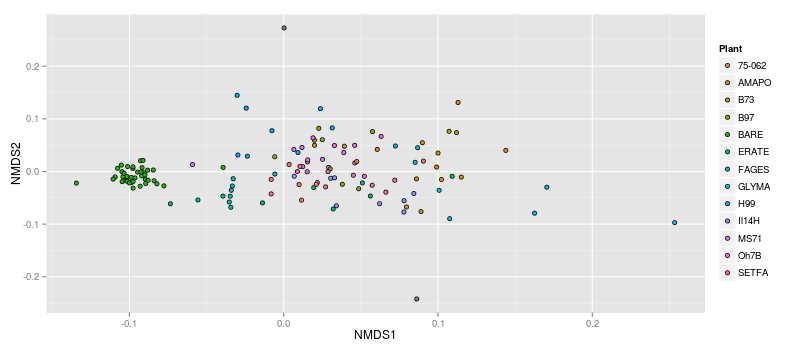

In [65]:
%%R -w 800 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

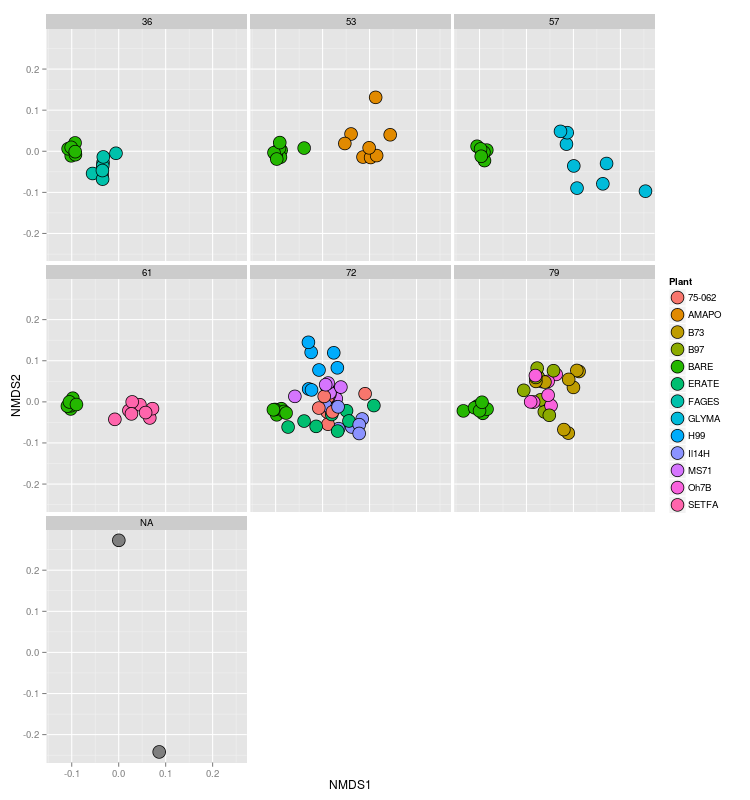

In [82]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

## NMDS of unweighted-unifrac distances

In [115]:
%%R
registerDoParallel(cores=28)

uwunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1444202 
Run 1 stress 0.1492893 
Run 2 stress 0.1487934 
Run 3 stress 0.1481523 
Run 4 stress 0.1444323 
... procrustes: rmse 0.03024693  max resid 0.1464908 
Run 5 stress 0.1532602 
Run 6 stress 0.1487296 
Run 7 stress 0.1433435 
... New best solution
... procrustes: rmse 0.03774531  max resid 0.2077033 
Run 8 stress 0.1449471 
Run 9 stress 0.1405469 
... New best solution
... procrustes: rmse 0.01491597  max resid 0.1286369 
Run 10 stress 0.1598466 
Run 11 stress 0.142926 
Run 12 stress 0.1614741 
Run 13 stress 0.1488652 
Run 14 stress 0.1460011 
Run 15 stress 0.1499228 
Run 16 stress 0.1429219 
Run 17 stress 0.1398994 
... New best solution
... procrustes: rmse 0.009110423  max resid 0.07576175 
Run 18 stress 0.1420373 
Run 19 stress 0.1449441 
Run 20 stress 0.1442309 


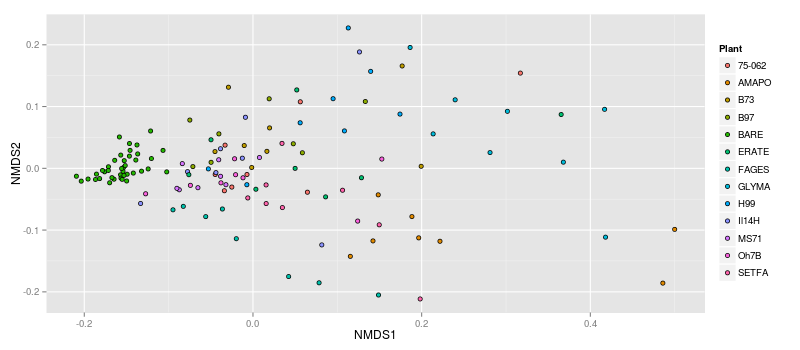

In [116]:
%%R -w 800 -h 350


nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = uwunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

#Heatmaps of taxon abundances



In [129]:
%%R
physeq.thresh %>% tax_table %>% head

Taxonomy Table:     [6 taxa by 8 taxonomic ranks]:
         Rank1      Rank2              Rank3                  
OTU.7277 "Bacteria" "__Acidobacteria"  "__32-21"              
OTU.430  "Bacteria" "__Proteobacteria" "__Deltaproteobacteria"
OTU.186  "Bacteria" "__Proteobacteria" "__Deltaproteobacteria"
OTU.5869 "Bacteria" "__Firmicutes"     "__Clostridia"         
OTU.5999 "Bacteria" "__Chloroflexi"    "__KD4-96"             
OTU.7637 "Bacteria" NA                 NA                     
         Rank4                    Rank5                    Rank6         
OTU.7277 "__uncultured_bacterium" NA                       NA            
OTU.430  "__Desulfobacterales"    "__Nitrospinaceae"       "__uncultured"
OTU.186  "__Desulfobacterales"    "__Nitrospinaceae"       "__uncultured"
OTU.5869 "__D8A-2"                "__uncultured_bacterium" NA            
OTU.5999 NA                       NA                       NA            
OTU.7637 NA                       NA                       NA   

In [140]:
%%R -w 800 
physeq.thresh.t50 <- prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:10]), physeq.thresh)

plot_heatmap(physeq.thresh.t50, sample.label='Plant', taxa.label='Rank2')

ggsave("heatmap_rank2.pdf")

Saving 11.1 x 6.67 in image


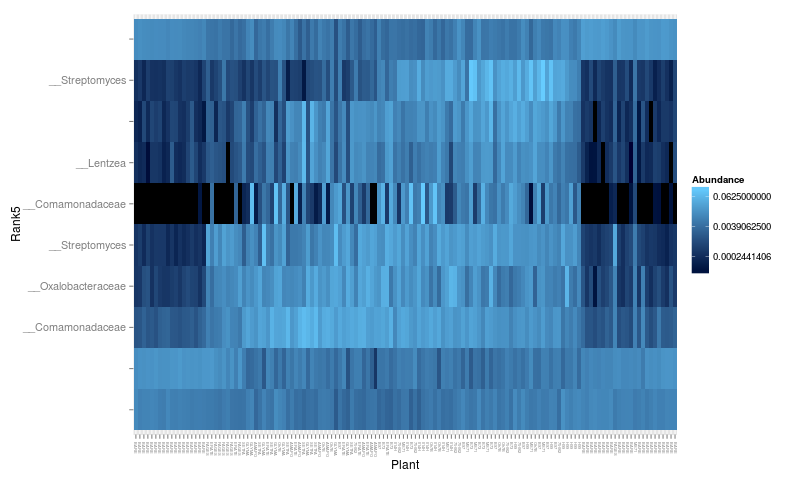

In [138]:
%%R -w 800 
physeq.thresh.t50 <- prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:10]), physeq.thresh)

plot_heatmap(physeq.thresh.t50, sample.label='Plant', taxa.label='Rank5')